In [2]:
# tau.py — strict port of MATLAB tau.m
import math

def tau(t, n, W0, m, M):
    # p=1-(1-t/M)^(n-1);
    p = 1.0 - (1.0 - t/float(M))**(n - 1)

    # X0 = (-1*M/2)*floor(W0/M)^2 + (W0-M/2)*floor(W0/M);
    f0 = math.floor(W0/float(M))
    X0 = (-1.0*float(M)/2.0)*(f0**2) + (W0 - float(M)/2.0)*f0

    # for k = 1:m
    #   W(k) = (W0+1)*2^k-1;   % correct (20.07.24)
    #   X(k) = (-1*M/2)*floor(W(k)/M)^2 + (W(k)-M/2)*floor(W(k)/M);
    # end
    X = []
    for k in range(1, m+1):
        Wk = (W0 + 1)*(2**k) - 1
        fk = math.floor(Wk/float(M))
        Xk = (-1.0*float(M)/2.0)*(fk**2) + (Wk - float(M)/2.0)*fk
        X.append(Xk)

    # switch m ... SUM
    if m == 0:
        pass  # no SUM used in this branch
    elif m == 1:
        SUM = 0.0
    elif m == 2:
        SUM = X[0]*p/2.0
    elif m == 3:
        SUM = (X[1]*(p**2))/4.0 + (X[0]*p)/2.0
    elif m == 4:
        SUM = (X[2]*(p**3))/8.0 + (X[1]*(p**2))/4.0 + (X[0]*p)/2.0
    elif m == 5:
        SUM = (X[3]*(p**4))/16.0 + (X[2]*(p**3))/8.0 + (X[1]*(p**2))/4.0 + (X[0]*p)/2.0
    elif m == 6:
        SUM = (X[4]*(p**5))/32.0 + (X[3]*(p**4))/16.0 + (X[2]*(p**3))/8.0 + (X[1]*(p**2))/4.0 + (X[0]*p)/2.0
    else:
        raise RuntimeError('this backoff stage value is not supported.')

    # switch m ... result
    if m == 0:
        # 마지막 대입이 유효 (주석된 대안식은 무시, 원본과 동일)
        result = t - (W0 + 1.0)/(W0 + 1.0 + X0)
    else:
        Xm = X[m-1]
        result = t - (W0 + 1.0)/( W0 + 1.0 + (1.0-p)*X0 + (1.0-p)*SUM + Xm*((p/2.0)**m) )
    return result


Elapsed time: 0.83 sec


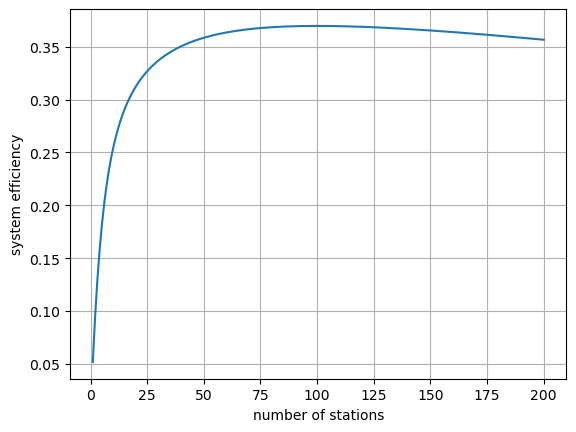

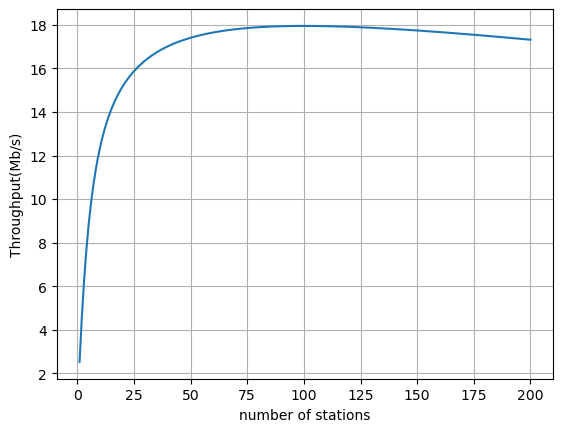

In [5]:
# calc_eff.py — port of calc_eff.m using tau()
import time, math
import numpy as np
import matplotlib.pyplot as plt

# fzero(@tau,[0,1],...) 대체
def fzero_like(func, a, b, args=(), max_iter=100, tol=1e-12, subdiv=1000):
    fa = func(a, *args)
    fb = func(b, *args)
    if fa == 0.0:
        return a
    if fb == 0.0:
        return b
    xs = np.linspace(a, b, subdiv+1)
    fs = np.array([func(x, *args) for x in xs])
    signs = np.sign(fs)
    for i in range(len(xs)-1):
        if signs[i] == 0:
            return xs[i]
        if signs[i]*signs[i+1] < 0:
            a_i, b_i = xs[i], xs[i+1]
            fa_i, fb_i = fs[i], fs[i+1]
            for _ in range(max_iter):
                m = 0.5*(a_i+b_i)
                fm = func(m, *args)
                if abs(fm) < tol or abs(b_i-a_i) < tol:
                    return m
                if fa_i*fm <= 0:
                    b_i, fb_i = m, fm
                else:
                    a_i, fa_i = m, fm
            return 0.5*(a_i+b_i)
    idx = int(np.argmin(np.abs(fs)))
    return float(xs[idx])

if __name__ == '__main__':
    # MATLAB params
    n = np.arange(1, 200+1)  # 1:200
    W0 = 31
    m = 5
    M = 8
    L_MPDU = 2000.0
    Data_Rate = 6.6667e6

    L_PHY = 40e-6
    L_Trigger = 100e-6
    L_BACK = 68e-6
    SIFS = 16e-6

    T = 8*L_MPDU/Data_Rate + 3*SIFS + 3*L_PHY + L_BACK

    tvals = np.zeros(len(n))
    pvals = np.zeros(len(n))
    eff   = np.zeros(len(n))
    Th    = np.zeros(len(n))
    Ds    = np.zeros(len(n))
    D     = np.zeros(len(n))

    t0 = time.time()

    for i, ni in enumerate(n):
        tval = fzero_like(lambda x, ni, W0, m, M: tau(x, ni, W0, m, M), 0.0, 1.0, args=(ni, W0, m, M))
        tvals[i] = tval
        pi = 1.0 - (1.0 - tval/M)**(ni - 1)
        pvals[i] = pi
        Ps  = tval*(1.0 - pi)
        Es  = ni*Ps
        eff[i] = Es/M

        Ptr = 1.0 - (1.0 - tval/M)**ni
        denom = 1.0 - (1.0 - (tval/M))**ni
        if denom == 0.0:
            Ps_ = 0.0
        else:
            Ps_ = ( ni*(tval/M)*(1.0 - (tval/M))**(ni - 1) ) / denom

        Th[i] = M*(Ptr*Ps_*8.0*L_MPDU) / ( (1.0-Ptr)*T + Ptr*Ps_*T + Ptr*(1.0-Ps_)*T )
        D[i]  = 1.0 / ( tval*(1.0 - (tval/M))**(ni - 1) ) if tval>0 else np.inf
        Ds[i] = 1.0 / ( 1.0 - (1.0 - tval*(1.0 - pi))**ni )

    # match MATLAB outputs
    tvals = tvals.reshape(-1,1)
    pvals = pvals.reshape(-1,1)
    eff   = eff.reshape(-1,1)
    ThMb  = (Th*1e-6).reshape(-1,1)
    Ds = Ds.reshape(-1,1)
    D  = D.reshape(-1,1)
    R  = np.hstack([n.reshape(-1,1), tvals, pvals, eff, ThMb, Ds, D])

    # Plots
    plt.figure(); plt.plot(n, eff); plt.grid(True)
    plt.xlabel('number of stations'); plt.ylabel('system efficiency')

    plt.figure(); plt.plot(n, Th*1e-6); plt.grid(True)
    plt.xlabel('number of stations'); plt.ylabel('Throughput(Mb/s)')

    elapsed = time.time() - t0
    print(f'Elapsed time: {elapsed:.2f} sec')
    plt.show()


Elapsed time: 506.20 sec


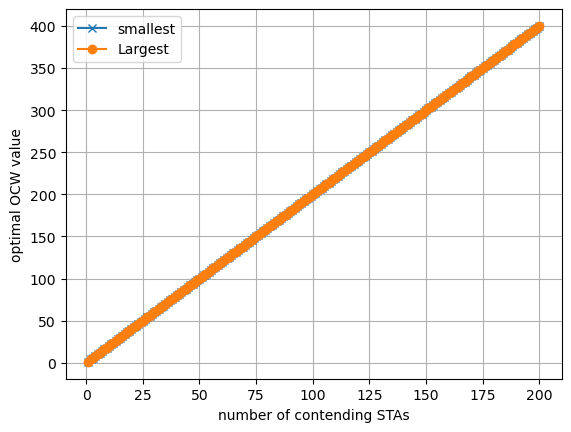

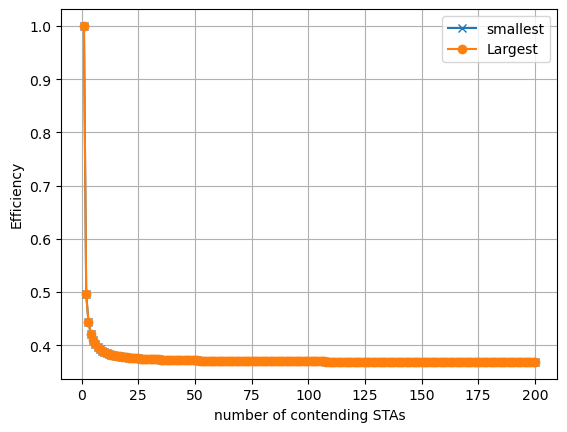

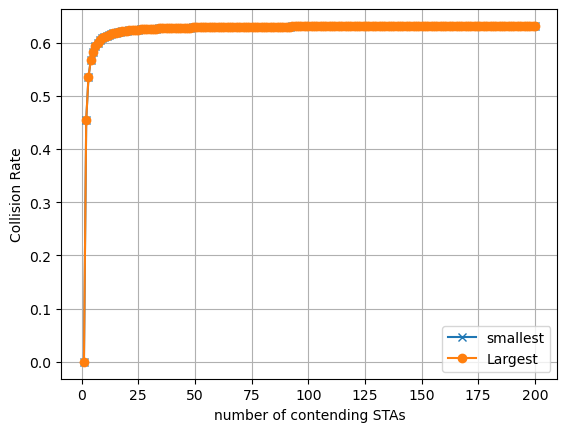

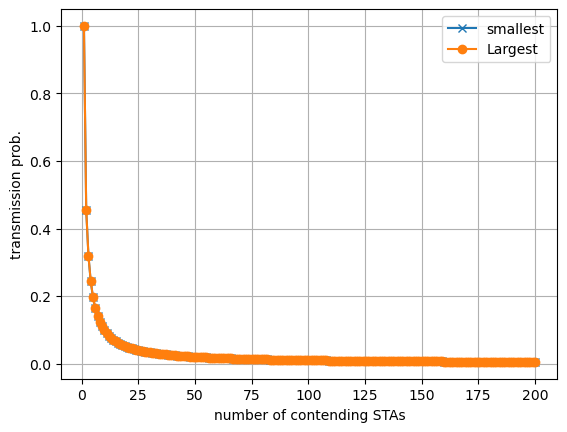

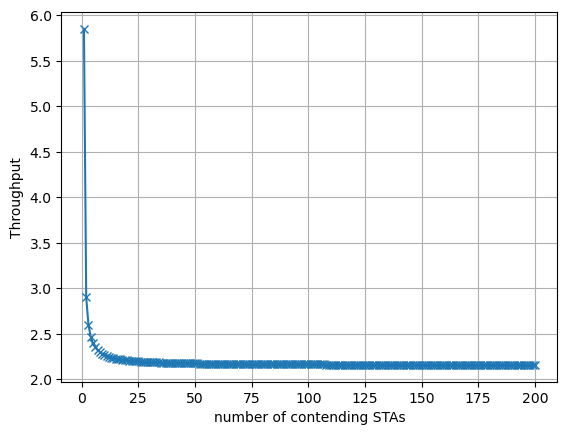

In [6]:
# calc_opt_ocw.py — port of Calc_Opt_OCW.m using tau()
import time, math
import numpy as np
import matplotlib.pyplot as plt

# fzero(@tau,[0,1],...) 대체: [0,1] 구간 세밀 분할 후 부호변화 구간에서 이분법
def fzero_like(func, a, b, args=(), max_iter=100, tol=1e-12, subdiv=1000):
    fa = func(a, *args)
    fb = func(b, *args)
    if fa == 0.0:
        return a
    if fb == 0.0:
        return b
    xs = np.linspace(a, b, subdiv+1)
    fs = np.array([func(x, *args) for x in xs])
    signs = np.sign(fs)
    for i in range(len(xs)-1):
        if signs[i] == 0:
            return xs[i]
        if signs[i]*signs[i+1] < 0:
            a_i, b_i = xs[i], xs[i+1]
            fa_i, fb_i = fs[i], fs[i+1]
            for _ in range(max_iter):
                m = 0.5*(a_i+b_i)
                fm = func(m, *args)
                if abs(fm) < tol or abs(b_i-a_i) < tol:
                    return m
                if fa_i*fm <= 0:
                    b_i, fb_i = m, fm
                else:
                    a_i, fa_i = m, fm
            return 0.5*(a_i+b_i)
    # 부호변화 못 찾으면 |f|가 최소인 점 반환 (fzero fallback 유사)
    idx = int(np.argmin(np.abs(fs)))
    return float(xs[idx])

if __name__ == '__main__':
    t0 = time.time()
    # MATLAB params
    n = np.arange(1, 200+1)        # 1:200
    W0_list = np.arange(1, 500+1)  # 1:500
    m = 0
    M = 1
    L_MPDU = 2000.0  # Byte
    Data_Rate = 6.6667e6

    L_PHY = 40e-6
    L_Trigger = 100e-6
    L_BACK = 68e-6
    SIFS = 16e-6

    T = 8*L_MPDU/Data_Rate + 3*SIFS + 3*L_PHY + L_BACK + L_Trigger

    R_eff = np.zeros((len(W0_list), len(n)))
    R_Pc  = np.zeros_like(R_eff)
    R_tau = np.zeros_like(R_eff)
    R_Th  = np.zeros_like(R_eff)

    # main loops
    for j, W0 in enumerate(W0_list):
        eff = np.zeros(len(n))
        p   = np.zeros(len(n))
        tvals = np.zeros(len(n))
        Th   = np.zeros(len(n))
        for i, ni in enumerate(n):
            # t(i)=fzero(@tau,[0,1],[],n(i),W0(j),m,M);
            tval = fzero_like(lambda x, ni, W0, m, M: tau(x, ni, W0, m, M), 0.0, 1.0, args=(ni, W0, m, M))
            tvals[i] = tval

            pi = 1.0 - (1.0 - tval/M)**(ni - 1)
            p[i] = pi
            Ps  = tval*(1.0 - pi)
            Es  = ni*Ps
            eff[i] = Es/M

            Ptr = 1.0 - (1.0 - tval/M)**ni
            # success probability given a transmission
            denom = 1.0 - (1.0 - (tval/M))**ni
            if denom == 0.0:
                Ps_ = 0.0
            else:
                Ps_ = ( ni*(tval/M)*(1.0 - (tval/M))**(ni - 1) ) / denom

            Pw = 1.0 - (1.0 - Ptr)**(M - 1)
            I  = (1.0 - Ptr)*(1.0 - Pw)*T + (1.0 - Ptr)*Pw*T
            Th[i] = M*(Ptr*Ps_*8.0*L_MPDU) / (I + Ptr*Ps_*T + Ptr*(1.0 - Ps_)*T)

        R_eff[j,:] = eff
        R_Pc[j,:]  = p
        R_tau[j,:] = tvals
        R_Th[j,:]  = Th

    # post-processing (same as MATLAB)
    Opt_OCW  = np.zeros(len(n), dtype=int)
    Opt_OCW2 = np.zeros(len(n), dtype=int)
    Opt_EFF1 = np.zeros(len(n))
    Opt_EFF2 = np.zeros(len(n))
    Opt_Pc1  = np.zeros(len(n))
    Opt_Pc2  = np.zeros(len(n))
    Opt_tau1 = np.zeros(len(n))
    Opt_tau2 = np.zeros(len(n))
    Opt_Th   = np.zeros(len(n))

    for i in range(len(n)):
        col = R_eff[:, i]
        maxv = np.max(col)
        idxs = np.where(col == maxv)[0]
        Opt_OCW[i]  = W0_list[idxs[0]]
        Opt_OCW2[i] = W0_list[idxs[-1]]

        Opt_EFF1[i] = R_eff[idxs[0], i]
        Opt_EFF2[i] = R_eff[idxs[-1], i]
        Opt_Pc1[i]  = R_Pc [idxs[0], i]
        Opt_Pc2[i]  = R_Pc [idxs[-1], i]
        Opt_tau1[i] = R_tau[idxs[0], i]
        Opt_tau2[i] = R_tau[idxs[-1], i]
        Opt_Th[i]   = R_Th [idxs[-1], i] * 1e-6  # Mb/s

    # plots
    plt.figure(); plt.plot(n, Opt_OCW, 'x-'); plt.plot(n, Opt_OCW2, 'o-'); plt.grid(True)
    plt.xlabel('number of contending STAs'); plt.ylabel('optimal OCW value')
    plt.legend(['smallest','Largest'])

    plt.figure(); plt.plot(n, Opt_EFF1, 'x-'); plt.plot(n, Opt_EFF2, 'o-'); plt.grid(True)
    plt.xlabel('number of contending STAs'); plt.ylabel('Efficiency')
    plt.legend(['smallest','Largest'])

    plt.figure(); plt.plot(n, Opt_Pc1, 'x-'); plt.plot(n, Opt_Pc2, 'o-'); plt.grid(True)
    plt.xlabel('number of contending STAs'); plt.ylabel('Collision Rate')
    plt.legend(['smallest','Largest'])

    plt.figure(); plt.plot(n, Opt_tau1, 'x-'); plt.plot(n, Opt_tau2, 'o-'); plt.grid(True)
    plt.xlabel('number of contending STAs'); plt.ylabel('transmission prob.')
    plt.legend(['smallest','Largest'])

    plt.figure(); plt.plot(n, Opt_Th, 'x-'); plt.grid(True)
    plt.xlabel('number of contending STAs'); plt.ylabel('Throughput')

    elapsed = time.time() - t0
    print(f'Elapsed time: {elapsed:.2f} sec')

    plt.show()
